# Task 1: Predictive generation storm image generation using 3D Convolutional neural networks(CNN)
## Imports

In [ ]:
%pylab inline
import torch
import torchvision
import random
import os
import zipfile
import io
import multiprocessing
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# The structure of my model
For this taks, I will train a 3D CNN model that containes three 3D convolutional layers and three linear fully connected layers. The reason for choosing the 3D CNN model is that I could fit a sequence of data as the depth, so that the network could record the sequential information while convoluting over the 3D image set.

In [ ]:
class Predictive3DCNN(nn.Module):
    def __init__(self, num_channels, depth, height, width, num_future_images):
        super(Predictive3DCNN, self).__init__()
        self.c1 = nn.Conv3d(in_channels=num_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.s1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.c2 = nn.Conv3d(16, 32, 3, stride=1, padding=1)
        self.s2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.c3 = nn.Conv3d(32, 64, 3, stride=1, padding=1)
        self.s3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.flattened_size = self.calculate_flattened_size(num_channels, depth, height, width)

        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_future_images * height * width)  # Output flattened future image

    def calculate_flattened_size(self, num_channels, depth, height, width):
        # Pass a dummy tensor through the convolutional layers to calculate the flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, num_channels, depth, height, width)
            dummy_output = self.conv_layers(dummy_input)
            return int(np.prod(dummy_output.size()))

    def conv_layers(self, x):
        x = self.s1(F.relu(self.c1(x)))
        x = self.s2(F.relu(self.c2(x)))
        x = self.s3(F.relu(self.c3(x)))
        return x

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, self.flattened_size)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer
        return x


# Customized dataset creation and dataloading
Because for each individual batch I would feed in a sequence of images as well as one label, I need to create a cutomized dataloader. Since I also want to train the model on all 30 storm to ensure the generalization ability, I would need to load a huge amount of image data. To solve a slow data loading issue I encounted, I created a code that instead loads a .zip file and decompressed to load all imagery all at onc. The code below will load up all the image from the zip into a dictionary, then, the create dataloader by grouping all images from one storm first by extracting the id. Lastly, initiate the final dataset by initiating list of sequence of images.

In [ ]:
class StormImageSequenceDataset(Dataset):
    def __init__(self, sequences, transform=None):
        self.sequences = sequences
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence, target = self.sequences[idx]
        if self.transform:
            sequence = [self.transform(image) for image in sequence]
            target = self.transform(target)
        sequence = torch.stack(sequence, dim=1)
        return sequence, target


# Load images from a zip file into RAM
def load_images_to_ram(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        images = {name: Image.open(io.BytesIO(zip_file.read(name))) for name in zip_file.namelist()}
        print(len(images))
    return images

# Extract the storm identifier from the filename
def extract_storm_id(filename):
    """
    Extract the storm identifier from the filename.

    The filename format is assumed to be 'shortcode_number.jpg' (e.g., 'bkh_001.jpg').
    The function returns the 'shortcode' part of the filename.
    """
    storm_id = filename.split('_')[0]
    return storm_id

# Group images by storm
def group_images_by_storm(images, sequence_length=9):
    grouped_images = {}
    for filename, image in images.items():
        storm_id = extract_storm_id(filename)  # Implement this function based on your naming convention
        if storm_id not in grouped_images:
            grouped_images[storm_id] = []
        grouped_images[storm_id].append((filename, image))

    # Sort images for each storm by filename (or another criterion if needed)
    for storm_id in grouped_images:
        grouped_images[storm_id].sort(key=lambda x: x[0])

    # Create sequences for each storm
    sequences = []
    for storm_id, storm_images in grouped_images.items():
        for i in range(len(storm_images) - sequence_length):
            sequence = [storm_images[j][1] for j in range(i, i + sequence_length)]
            target = storm_images[i + sequence_length][1]
            sequences.append((sequence, target))

    return sequences


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Storm/all_storm_image.zip'

# Load all images into RAM
images = load_images_to_ram(zip_path)

# Group images by storm and create sequences
sequences = group_images_by_storm(images)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Initialize the dataset
dataset = StormImageSequenceDataset(sequences, transform=transform)

# Split the dataset into training and test sets
train_dataset, test_dataset = random_split(dataset, [len(dataset) - 1, 1])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
9527


# Creating the training function and train

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for sequence, target in dataloader:
        # Move data to the appropriate device (CPU or GPU)
        sequence = sequence.to(device)
        target = target.to(device)

        # Flatten the target tensor
        # Assuming 'target' is your target tensor with shape [batch_size, channels, height, width]
        flattened_target = target.view(target.size(0), -1)  # Reshapes to [batch_size, channels*height*width]

        #print(flattened_target.shape)

        # Forward pass
        output = model(sequence)
        #print(output.shape)
        loss = criterion(output, flattened_target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    return average_loss


# Example of model initialization
num_channels = 1  # Assuming grayscale images, 1 channel per image
depth = 9  # Number of images in each sequence
height, width = 200, 200  # Dimensions of each image
num_future_images = 1  # Number of future images to predict

model = Predictive3DCNN(num_channels, depth, height, width, num_future_images)

# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    avg_loss = train(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/20, Loss: 0.6852
Epoch 2/20, Loss: 0.3521
Epoch 3/20, Loss: 0.2781
Epoch 4/20, Loss: 0.2510
Epoch 5/20, Loss: 0.2297
Epoch 6/20, Loss: 0.2141
Epoch 7/20, Loss: 0.2024
Epoch 8/20, Loss: 0.1944
Epoch 9/20, Loss: 0.1864
Epoch 10/20, Loss: 0.1791
Epoch 11/20, Loss: 0.1735
Epoch 12/20, Loss: 0.1686
Epoch 13/20, Loss: 0.1639
Epoch 14/20, Loss: 0.1579
Epoch 15/20, Loss: 0.1538
Epoch 16/20, Loss: 0.1517
Epoch 17/20, Loss: 0.1470
Epoch 18/20, Loss: 0.1440
Epoch 19/20, Loss: 0.1415
Epoch 20/20, Loss: 0.1388


# Evaluate and predict

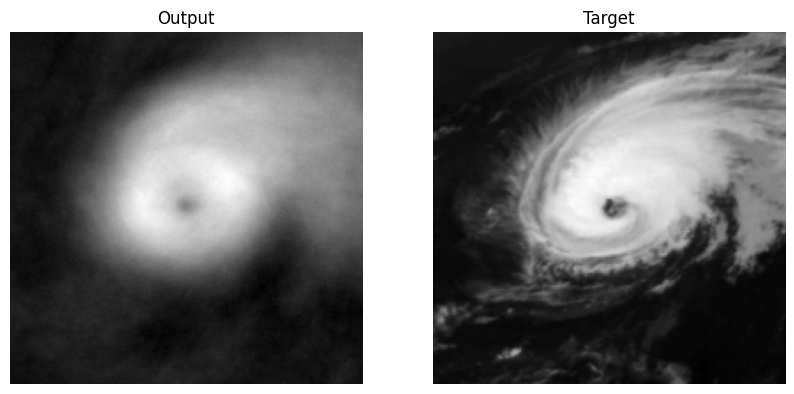

Average MSE: 0.0756, Average SSIM: 0.2408


In [34]:
def plot_output_target(output, target):
    # Assuming output and target are PyTorch tensors of shape [batch_size, channels, height, width]
    # and you want to plot the first image in the batch

    # Convert to numpy and move channel to the last dimension for plotting
    output_img = output[0].permute(1, 2, 0).cpu().numpy()
    target_img = target[0].permute(1, 2, 0).cpu().numpy()

    # If the images are single-channel (grayscale), convert them to 2D
    if output_img.shape[2] == 1:
        output_img = output_img.squeeze(2)  # Remove channel dimension
    if target_img.shape[2] == 1:
        target_img = target_img.squeeze(2)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(output_img, cmap='gray')  # Use 'gray' colormap for grayscale images
    axes[0].set_title('Predict')
    axes[0].axis('off')  # Turn off axis ticks and labels

    axes[1].imshow(target_img, cmap='gray')
    axes[1].set_title('Target')
    axes[1].axis('off')

    plt.show()

def evaluate_model(model, data_loader, device):
    model.eval()
    mse_loss = nn.MSELoss()
    total_mse = 0.0
    total_ssim = 0.0
    total_samples = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = output.view_as(target)

            mse = mse_loss(output, target)
            total_mse += mse.item() * data.size(0)

            output_np = output.detach().cpu().numpy()
            target_np = target.detach().cpu().numpy()

            out_2d = np.squeeze(output_np)
            tar_2d = np.squeeze(target_np)

            # Ensure the images are in the shape (200, 200)
            assert out_2d.shape == (200, 200)
            assert tar_2d.shape == (200, 200)

            # Calculate SSIM for the pair of images
            single_ssim = ssim(out_2d, tar_2d, data_range=1.0)

            total_ssim += single_ssim
            total_samples += data.size(0)

    avg_mse = total_mse / total_samples
    avg_ssim = total_ssim / total_samples
    return avg_mse, avg_ssim

# Example usage (assuming you have a batch of data and target from your DataLoader)
# Make sure the model is in evaluation mode and gradients are turned off
# Example usage
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients
    for data, target in test_loader:
        # Move data to the device where the model is
        data = data.to(device)

        output = model(data)
        output = output.view_as(target)

        # Detach the output and target from the current graph and move to CPU
        output = output.detach().cpu()
        target = target.detach().cpu()

        plot_output_target(output,target)
        # plot_output_target(output, target)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # Evaluate the model
        avg_mse, avg_ssim = evaluate_model(model, test_loader, device)
        print(f"Average MSE: {avg_mse:.4f}, Average SSIM: {avg_ssim:.4f}")

        break  # Remo
